# Analysis functions

In [100]:
import numpy as np
from scipy.optimize import fsolve
import datetime
import json
from nupack import *
from matplotlib import pyplot as plt
import re
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq
from scipy.integrate import odeint
from matplotlib.patches import Patch
from scipy.stats import linregress

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Helper funtions
def to_seconds(time_series):
  split_string = lambda timestring: re.split(':', timestring)
  time = [float(split_string(value)[0])*3600 + float(split_string(value)[1])*60 + float(split_string(value)[2]) for value in time_series]
  return time

def getEndpoint(level, x, data, conditions):
    averages = []

    for i, c in enumerate(data.columns):
        col = c
        if lookupCondition(col, conditions) == level:
            y = [float(i) for i in data[col].values]
            avg = np.average(y[-10:])
            averages.append(avg)

    df = pd.DataFrame(averages).T
    df.columns = ['Average '+str(i+1) for i in range(len(averages))]
    df.insert(0, "Level", level)  # Insert the level name as the first column
    df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
    df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

    return df
  
  
def getAverageCurve(startTime, offset, level, x, data, conditions, fit):
    """
    Calculate the average curve and standard deviation from data columns based on certain conditions.

    Args:
    - startTime (float): Start time to begin averaging from.
    - offset (float): Offset for the x values.
    - level: Condition level to filter the data columns.
    - x (list): x values for the curve.
    - data (DataFrame): Data containing the curve data in its columns.
    - conditions: Conditions corresponding to each data column.
    - fit (tuple): Tuple containing two fit values.

    Returns:
    - tuple: x values, average y values, and standard deviation of y values.
    """

    y_curves = []

    for i, c in enumerate(data.columns):
        if i >= 2 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_curves.append(ynew)

    y_avg, y_std = average_and_std(y_curves)
    x_vals = [i + offset - startTime for i in x if i >= startTime]

    return x_vals, y_avg, y_std 
  
def completion_at_time(data,
                      baseline_data,
                      triggered_data,
                      time_list_seconds,
                      time_in_seconds,
                      conditions,
                      baseline_conditions,
                      triggered_conditions,
                      experimental_level,
                      base_line_level,
                      triggered_level,
                      verbose = False):


  def progegate_uncertainty_averaged_stddev(std_dev_list):
    return np.sqrt(sum(s**2 for s in std_dev_list)/(len(std_dev_list)**2))

  def average_last_n_with_std(n, average_series, std_series):
    av = average_series[-n:].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[-n:].values)
    return av, std
  def average_first_n_with_std(n, average_series, std_series):
    av = average_series[:n].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[:n].values)
    return av, std
  def calculate_completion_level(V, T, B):
    return (float(V) - float(B))/(float(T) - float(B))
  def series_av_and_std(dat, cond, level_name):
    target_columns = cond[level_name]
    dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
    average_by_point = dat[target_columns].mean(axis=1)
    std_by_point = dat[target_columns].std(axis=1)
    return average_by_point, std_by_point

  #Get the x-values in seconds
  x = time_list_seconds
  #Fine the index of the first datapoint greater than time in seconds
  desired_time_index = min([i for i, time in enumerate(x) if time >= time_in_seconds])
  #Fist calculate baseline average and uncertainty at LAST AVAILABLE 5 DATAPOINTS
  base_line_average, base_line_std = average_first_n_with_std(5, *series_av_and_std(baseline_data, baseline_conditions, base_line_level))
  #Next calculate the triggering average and uncerainty at LAST 5 AVAILABLE DATAPOINTS
  triggered_average, triggered_std = average_last_n_with_std(5, *series_av_and_std(triggered_data, triggered_conditions, triggered_level))
  completion_levels = []
  for l_name in conditions[experimental_level]:
    completion_levels += [calculate_completion_level(data[l_name][desired_time_index], triggered_average, base_line_average)]

  if verbose:
    print(f"{experimental_level} : {np.average(completion_levels)} +/- {np.std(completion_levels)}")
  return np.average(completion_levels), np.std(completion_levels)

def getInitial(level, x, data, conditions):
  averages = []

  for i, c in enumerate(data.columns):
      col = c
      if lookupCondition(col, conditions) == level:
          y = [float(i) for i in data[col].values]
          avg = np.average(y[0:10])
          averages.append(avg)

  df = pd.DataFrame(averages).T
  df.columns = ['Average '+str(i+1) for i in range(len(averages))]
  df.insert(0, "Level", f"{level} init")  # Insert the level name as the first column
  df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
  df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

  return df

def timeToSec(time_string):
  split_string = time_string.split(":")
  return int(split_string[0])*3600 + int(split_string[1])*60 + int(split_string[2])

def lookupCondition(columnHeader, conds):
    keys = conds.keys()
    count = 0
    out = ""
    for e in conds.values():
        if columnHeader in e:
            count += 1
            out = list(conds.keys())[list(conds.values()).index(e)]
    assert(count <= 1)
    
    return out
  
def plotCalibratedAverages(level, x, ax, data, conditions, fit, color_dict, format_dict=None):
    data_list = []
    for i, c in enumerate(data.columns):
        col = c 
        if i>= 2 and lookupCondition(col, conditions) == level:
            ynew = [(float(x) - fit[0])/fit[1] for x in data[col].values]
            data_list.append(ynew)
            
    data_array = np.array(data_list)
    y_mean = np.mean(data_array, axis=0)
    y_std = np.std(data_array, axis=0)
    
    lab = 'Av' + level
    color = color_dict[level] if level in color_dict else 'blue' # set default color to blue

    if format_dict is None:
        format_dict = {'point_size': 1, 'point_opacity': 0.6, 'fill_opacity': 0.5}

    point_size = format_dict.get('point_size', 1)
    point_opacity = format_dict.get('point_opacity', 0.6)
    fill_opacity = format_dict.get('fill_opacity', 0.5)

    ax.scatter(x, y_mean, label=lab, color=color, alpha=point_opacity, s=[point_size]*len(y_mean))
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=fill_opacity)
    
  
def getTriplicatesJackknife(startTime, offset, level, x, data, conditions, fit):
    """
    Leave-one-out version of getAverageCurve.
    Returns 3 average curves and their standard deviations, each leaving out one replicate.

    Args:
    - startTime (float): Start time for truncating the curves.
    - offset (float): Time offset to apply to x values.
    - level: Condition label to match columns.
    - x (list or array): Full time array.
    - data (DataFrame): Curve data in columns.
    - conditions (dict): Mapping of column names to experimental conditions.
    - fit (tuple): Background subtraction and normalization (offset, scale).

    Returns:
    - x_vals (list): Timepoints corresponding to returned curves.
    - y_curves (list of 3 lists): Each is a leave-one-out average curve.
    - y_stds   (list of 3 lists): Each is the std deviation matching the y_curves.
    """
    y_all = []
    for i, c in enumerate(data.columns):
        if i >= 1 and lookupCondition(c, conditions) == level:
            ynew = [(float(data[c].values[z]) - fit[0]) / fit[1] for z in range(len(data[c].values)) if float(x[z]) >= startTime]
            y_all.append(ynew)

    if len(y_all) != 3:
        print(conditions[level])
        for y in y_all:
          print(y[0:10])
        raise ValueError(f"Expected 3 replicates, found {len(y_all)} for level {level}")

    x_vals = [i + offset - startTime for i in x if i >= startTime]

    y_curves = []
    y_stds = []

    for i in range(3):
        subset = [y for j, y in enumerate(y_all) if j != i]
        avg, std = average_and_std(subset)
        y_curves.append(avg)
        y_stds.append(std)

    return x_vals, y_curves, y_stds


def average_and_std(curves):
    curves_array = np.array(curves)
    mean_curve = np.mean(curves_array, axis=0)
    std_curve = np.std(curves_array, axis=0)
    return mean_curve.tolist(), std_curve.tolist()

# TUM Single step

## Importing data

In [59]:
UW_backgr = pd.read_csv("UW_backgr.csv")
conditions_UW_backgr = {'R alone' : ['B2', 'C2', 'D2'],
'N50_80uM: 25000.0 nM, R1_1uM_cal: 40.0 nM' : ['B3', 'C3', 'D3'],
'R(nn) alone' : ['E2', 'F2', 'G2'],
'N50_80uM: 25000.0 nM, R1(nn)_1uM_cal: 40.0 nM' : ['E3', 'F3', 'G3']}
offset_UW_backgr = 0
t_UW_backgr = [offset_UW_backgr  + timeToSec(i) for i in list(UW_backgr['Time'].values)]
UW_trig = pd.read_csv("UW_trig.csv")
conditions_UW_trig = {'R background' : ['E9', 'F9', 'G9'],
              'no background nat' : ['E13', 'F13', 'G13'],
              'Trig N50_25uM nat' : ['E11', 'F11', 'G11'],
              'R(nn) background' : ['H9', 'I9', 'J9'],
              'no background nn' : ['H13', 'I13', 'J13'],
              'Trig N50_25uM nn' : ['H11', 'I11', 'J11']}
offset_UW_trig = 140
t_UW_trig = [offset_UW_trig  + timeToSec(i) for i in list(UW_trig['Time'].values)]


UW_rep = pd.read_csv("UW_rep.csv")
conditions_UW_rep = {'R background' : ['E8', 'F8', 'G8'],
              'no background nat' : ['E12', 'F12', 'G12'],
              'Rep N50_25uM nat' : ['E10', 'F10', 'G10'],
              'R(nn) background' : ['H8', 'I8', 'J8'],
              'no background nn' : ['H12', 'I12', 'J12'],
              'Rep N50_25uM nn' : ['H10', 'I10', 'J10']}
offset_UW_rep = 140
t_UW_rep = [offset_UW_rep + timeToSec(i) for i in list(UW_rep['Time'].values)]


UW_no = pd.read_csv("UW_no.csv")
conditions_UW_no = {'no background nat' : ['E3', 'F3', 'G3'],
'R background' : ['E4', 'F4', 'G4'],
'No N50_25uM nat' : ['E5', 'F5', 'G5'],
'no background nn' : ['H3', 'I3', 'J3'],
'R(nn) background' : ['H4', 'I4', 'J4'],
'No N50_25uM nn' : ['H5', 'I5', 'J5']}
offset_UW_no = 140
t_UW_no = [offset_UW_no + timeToSec(i) for i in list(UW_no['Time'].values)]


TUM_controls = pd.read_csv("TUM_controls.csv")
conditions_TUM_controls = {'buffer alone' : ['Buffer_1',	'Buffer_2',	'Buffer_3'],
                          'R alone' : ['R_1',	'R_2',	'R_3'],
                          'R(nn) alone' : ['R(nn)_1',	'R(nn)_2',	'R(nn)_3'],
                          'no background nat' : ['OneStep_1',	'OneStep_2',	'OneStep_3'],
                          'no background nn' : ['OneStep(nn)_1',	'OneStep(nn)_2',	'OneStep(nn)_3']}
offset_TUM_controls = 0
t_TUM_controls = [int(t) + offset_TUM_controls for t in TUM_controls['time'].values]

TUM_no = pd.read_csv("TUM_no.csv")
conditions_TUM_no = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     }
offset_TUM_no = 0
t_TUM_no = [int(t) + offset_TUM_no for t in TUM_no['time'].values]

TUM_trig = pd.read_csv("TUM_trig.csv")
conditions_TUM_trig = {'Trig inc nat N25-10uM' : ['Trig inc N25-10µM_1',	'Trig inc N25-10µM_2',	'Trig inc N25-10µM_3'],
                       'Trig inc nat N25-25uM' : ['Trig inc N25-25µM_1',	'Trig inc N25-25µM_2',	'Trig inc N25-25µM_3'],
                       'Trig inc nat N50-10uM' : ['Trig inc N50-10µM_1',	'Trig inc N50-10µM_2',	'Trig inc N50-10µM_3'],
                       'Trig inc nat N50-25uM' : ['Trig inc N50-25µM_1',	'Trig inc N50-25µM_2',	'Trig inc N50-25µM_3'],
                       'Trig inc nn N25-10uM' : ['Trig inc N25-10µM(nn)_1',	'Trig inc N25-10µM(nn)_2',	'Trig inc N25-10µM(nn)_3'],
                       'Trig inc nn N25-25uM' : ['Trig inc N25-25µM(nn)_1',	'Trig inc N25-25µM(nn)_2',	'Trig inc N25-25µM(nn)_3'],
                       'Trig inc nn N50-10uM' : ['Trig inc N50-10µM(nn)_1',	'Trig inc N50-10µM(nn)_2',	'Trig inc N50-10µM(nn)_3'],
                       'Trig inc nn N50-25uM' : ['Trig inc N50-25µM(nn)_1',	'Trig inc N50-25µM(nn)_2',	'Trig inc N50-25µM(nn)_3'],
                       }
offset_TUM_trig = 0
t_TUM_trig = [int(t) + offset_TUM_trig for t in TUM_trig['time'].values]


TUM_rep = pd.read_csv("TUM_rep.csv")
conditions_TUM_rep = {'Rep inc nat N25-10uM' : ['Trig inc N25-10µM_1',	'Trig inc N25-10µM_2',	'Trig inc N25-10µM_3'],
                       'Rep inc nat N25-25uM' : ['Trig inc N25-25µM_1',	'Trig inc N25-25µM_2',	'Trig inc N25-25µM_3'],
                       'Rep inc nat N50-10uM' : ['Trig inc N50-10µM_1',	'Trig inc N50-10µM_2',	'Trig inc N50-10µM_3'],
                       'Rep inc nat N50-25uM' : ['Trig inc N50-25µM_1',	'Trig inc N50-25µM_2',	'Trig inc N50-25µM_3'],
                       'Rep inc nn N25-10uM' : ['Trig inc N25-10µM(nn)_1',	'Trig inc N25-10µM(nn)_2',	'Trig inc N25-10µM(nn)_3'],
                       'Rep inc nn N25-25uM' : ['Trig inc N25-25µM(nn)_1',	'Trig inc N25-25µM(nn)_2',	'Trig inc N25-25µM(nn)_3'],
                       'Rep inc nn N50-10uM' : ['Trig inc N50-10µM(nn)_1',	'Trig inc N50-10µM(nn)_2',	'Trig inc N50-10µM(nn)_3'],
                       'Rep inc nn N50-25uM' : ['Trig inc N50-25µM(nn)_1',	'Trig inc N50-25µM(nn)_2',	'Trig inc N50-25µM(nn)_3'],
                       }
offset_TUM_rep = 0
t_TUM_rep = [int(t) + offset_TUM_rep for t in TUM_rep['time'].values]

# One step

## Controls

In [60]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]
number_of_points = 6*3600//60

Fitted kf = 7.6e+03 ± 5.4e+02


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_59623/944145527.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


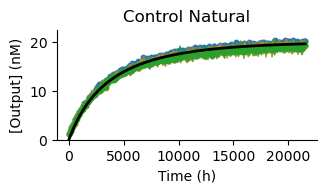

In [61]:
import math



data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[3]]
offset = offset_TUM_controls
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_controls[0:number_of_points])



format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]

to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]





def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt

        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result




# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

fitted_kf = np.mean(res)
param_sd_kf = np.std(res)

print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


k_control_nat = [[fitted_kf,param_sd_kf]]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nat_k.svg', dpi = 400)
plt.show()



Fitted kf = 2.2e+04 ± 8.1e+02


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_59623/3517148518.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


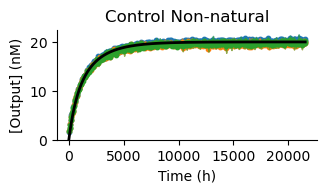

In [62]:
data = TUM_controls[0:number_of_points]
conditions = conditions_TUM_controls
levels = [list(conditions.keys())[4]]
offset = offset_TUM_controls
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_controls[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]




to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]




def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result



# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

fitted_kf = np.mean(res)
param_sd_kf = np.std(res)

print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


k_control_nn = [[fitted_kf,param_sd_kf]]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Non-natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')

#plt.savefig('control_nnn_k.svg', dpi = 400)

plt.show()



## No incubations

### Nat

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_59623/1953897969.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kb_off = float(kb_off)


Fitted kr_s = 51.18 ± 1.19
Fitted kr_s = 40.33 ± 0.42
Fitted kr_s = 4.00 ± 0.43
Fitted kr_s = 3.83 ± 0.18


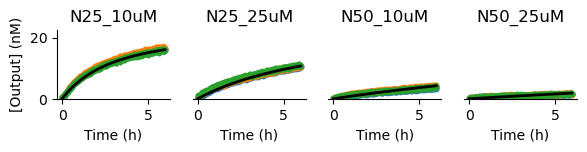

In [68]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kb_off, tArray, fixed_params):
    t = tArray
    # Unpack the input parameters
    y0, kf, scale = fixed_params['y0'], fixed_params['kf'], fixed_params['scale']
    y0 = y0[0:1] + [scale] + y0[1:]
    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale
    kb_off = float(kb_off)
    def translatorModel(y, t, kb_off, kf, scale):
        kb_off = float(kb_off)

        Y1, R1, P, W, B, S = y
        # CRN:
        # Y1 + R1 -krep> P + W
        # Y1 + B <-kb_off kb_on->  S
        #Rate of reporting
        kb_on = 1e7
        dR1dt = -float(kf*(R1)*(Y1))
        dY1dt = -float(kf*(R1)*(Y1)) -float(kb_on*(B)*(Y1)) + float(kb_off*S)
        dPdt = float(kf*(R1)*(Y1))
        dWdt = dPdt
        dBdt = -float(kb_on*(B)*(Y1)) + float(kb_off*S)
        dSdt = float(kb_on*(B)*(Y1)) - float(kb_off*S)

        return (dY1dt, dR1dt, dPdt, dWdt, dBdt, dSdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-3] for i in odeint(translatorModel, y0, t, args=(kb_off, kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1


def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





B_concs = [10000, 25000, 10000, 25000]
# Initial parameters
y_init = [
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[0],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[1],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[2],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[3],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)  
]

scale = 40

k_cont = k_control_nat[0][0]
fixed_params_list = [
    [{'y0': y_init[0], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[1], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[2], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[3], 'kf': k_cont, 'scale' : scale}]
]


initial_k = [50, 40, 1, 1]

x_list  = [x_trunc]




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2


kb_no_nat = []
x_trunc_h = [t/3600 for t in x_trunc]
x_h = [t/3600 for t in x]
for i,a in enumerate(ax):
    

    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        r = fit_modelOneStep(x_list, [curve], initial_k[i], fixed_params_list[i])[0][0]
        res.append(r)

        a.scatter(x_trunc_h,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc_h,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc_h,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

    fitted_kf = np.mean(res)
    param_sd_kf = np.std(res)
    kb_no_nat.append([fitted_kf, param_sd_kf])
    print(f"Fitted kr_s = {fitted_kf:.2f} ± {param_sd_kf:.2f}")

    #k_no_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i][0])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



In [69]:
def kb_to_e(kb, e_kb):
    RT = 0.592
    f = -RT*np.log(1e7/kb)
    dfit = (-1e7/(kb**2))*(-RT*(1/(1e7/kb)))
    df = np.sqrt((dfit*e_kb)**2)
    return f, df

for fit in kb_no_nat:
    e, s = kb_to_e(fit[0], fit[1])
    print(f"{e:.3f} +/- {s:.3f}")


-7.212 +/- 0.014
-7.353 +/- 0.006
-8.722 +/- 0.064
-8.747 +/- 0.028


### NN

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_59623/3001254846.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kb_off = float(kb_off)


Fitted  kr_s = 54.94 ± 1.52
Fitted  kr_s = 68.35 ± 3.07
Fitted  kr_s = 10.47 ± 1.07
Fitted  kr_s = 6.81 ± 0.27


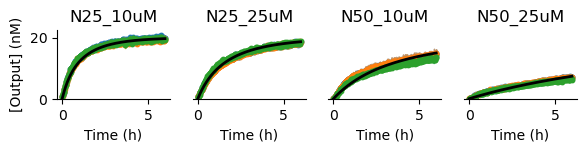

In [71]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1, 3, 5, 7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kb_off, tArray, fixed_params):
    t = tArray
    # Unpack the input parameters
    y0, kf, scale = fixed_params['y0'], fixed_params['kf'], fixed_params['scale']
    y0 = y0[0:1] + [scale] + y0[1:]
    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale
    kb_off = float(kb_off)
    def translatorModel(y, t, kb_off, kf, scale):
        kb_off = float(kb_off)

        Y1, R1, P, W, B, S = y
        # CRN:
        # Y1 + R1 -krep> P + W
        # Y1 + B <-kb_off kb_on->  S
        #Rate of reporting
        kb_on = 1e7
        dR1dt = -float(kf*(R1)*(Y1))
        dY1dt = -float(kf*(R1)*(Y1)) -float(kb_on*(B)*(Y1)) + float(kb_off*S)
        dPdt = float(kf*(R1)*(Y1))
        dWdt = dPdt
        dBdt = -float(kb_on*(B)*(Y1)) + float(kb_off*S)
        dSdt = float(kb_on*(B)*(Y1)) - float(kb_off*S)

        return (dY1dt, dR1dt, dPdt, dWdt, dBdt, dSdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-3] for i in odeint(translatorModel, y0, t, args=(kb_off, kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1


def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





B_concs = [10000, 25000, 10000, 25000]

# Initial parameters
y_init = [
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[0],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[1],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[2],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[3],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)  
]

scale = 40

k_cont = k_control_nn[0][0]
fixed_params_list = [
    [{'y0': y_init[0], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[1], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[2], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[3], 'kf': k_cont, 'scale' : scale}]
]


initial_k = [51, 60, 5, 1]

x_list  = [x_trunc]




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2


kb_no_nn = []
x_trunc_h = [t/3600 for t in x_trunc]
x_h = [t/3600 for t in x]
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        r = fit_modelOneStep(x_list, [curve], initial_k[i], fixed_params_list[i])[0][0]
        res.append(r)

        a.scatter(x_trunc_h,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc_h,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc_h,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    fitted_kf = np.mean(res)
    param_sd_kf = np.std(res)
    kb_no_nn.append([fitted_kf, param_sd_kf])
    print(f"Fitted  kr_s = {fitted_kf:.2f} ± {param_sd_kf:.2f}")

    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i][0])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()


In [72]:
def kb_to_e(kb, e_kb):
    RT = 0.592
    f = -RT*np.log(1e7/kb)
    dfit = (-1e7/(kb**2))*(-RT*(1/(1e7/kb)))
    df = np.sqrt((dfit*e_kb)**2)
    return f, df

for fit in kb_no_nat:
    e, s = kb_to_e(fit[0], fit[1])
    print(f"{e:.3f} +/- {s:.3f}")


-7.212 +/- 0.014
-7.353 +/- 0.006
-8.722 +/- 0.064
-8.747 +/- 0.028


# Cascade

## Importing Data

In [73]:
UW_controls = pd.read_csv('UW_Cascades.csv')
conditions_UW_controls = {'R alone' : ['B10', 'C10', 'D10'], #actually cascade alone
                          'R(nn) alone' : ['E10', 'F10', 'G10']}
offset_UW_controls = 0
t_UW_controls = [timeToSec(t) + offset_UW_controls for t in UW_controls['Time'].values]

UW_casc_controls = pd.read_csv('UW_Cascades.csv')
conditions_UW_casc_controls = {'Cascade' : ['B5', 'C5', 'D5'],
                                'Cascade(nn)' : ['E5', 'F5', 'G5']}
offset_UW_casc_controls = 0
t_UW_casc_controls = [timeToSec(t) + offset_UW_casc_controls for t in UW_casc_controls['Time'].values]


UW_trig = pd.read_csv('UW_Cascades.csv')
conditions_UW_trig = {'N50_25uM nat' : ['B9', 'C9', 'D9'],
                      'N50_25uM nn' : ['E9', 'F9', 'G9']}
offset_UW_trig = 190
t_UW_trig = [timeToSec(t) + offset_UW_trig for t in UW_trig['Time'].values]


UW_casc = pd.read_csv('UW_Cascades.csv')
conditions_UW_casc = {'N50_25uM nat' : ['B8', 'C8', 'D8'],
                     'N50_25uM nn' : ['E8', 'F8', 'G8']}
offset_UW_casc = 190
t_UW_casc = [timeToSec(t) + offset_UW_casc for t in UW_casc['Time'].values]


UW_no = pd.read_csv('UW_Cascades.csv')

conditions_UW_no = {'N50_25uM nat' : ['B13', 'C13', 'D13'],
             'N50_25uM nn' : ['E13', 'F13', 'G13']}
offset_UW_no = 190
t_UW_no = [timeToSec(t) + offset_UW_no for t in UW_no['Time'].values]



TUM_controls = pd.read_csv('TUM_Controls.csv')
conditions_TUM_controls = {'buffer alone' : ['Buffer_1',	'Buffer_2',	'Buffer_3'],
                          'R alone' : ['R_1',	'R_2',	'R_3'],
                          'R(nn) alone' : ['R(nn)_1',	'R(nn)_2',	'R(nn)_3']}
offset_TUM_controls = 0
t_TUM_controls = [int(t) + offset_TUM_controls for t in TUM_controls['time'].values]

TUM_casc_controls = pd.read_csv('TUM_Cascades_NoIncub.csv')
conditions_TUM_casc_controls = {'Cascade' : ['Cascade_1',	'Cascade_2',	'Cascade_3'],
                                'Cascade(nn)' : ['Cascade(nn)_1',	'Cascade(nn)_2',	'Cascade(nn)_3']}
offset_TUM_casc_controls = 0
t_TUM_casc_controls = [int(t) + offset_TUM_casc_controls for t in TUM_casc_controls['time'].values]


TUM_no = pd.read_csv('TUM_Cascades_NoIncub.csv')
conditions_TUM_no = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                     'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                     }
offset_TUM_no = 0
t_TUM_no = [int(t) + offset_TUM_no for t in TUM_no['time'].values]


TUM_trig = pd.read_csv('TUM_Cascades_TrigIncub.csv')
conditions_TUM_trig = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                     'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                     }
offset_TUM_trig = 0
t_TUM_trig = [int(t) + offset_TUM_trig for t in TUM_trig['time'].values]


TUM_casc = pd.read_csv('TUM_Cascades_CascIncub.csv')
conditions_TUM_casc = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                       'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                       'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                       'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                       'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                       'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                       'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                       'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                        'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                        'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                        }
offset_TUM_casc = 0
t_TUM_casc = [int(t) + offset_TUM_casc for t in TUM_casc['time'].values]



## Controls

In [74]:
fit_nat = [3962.800000, (16755.433333-3962.800000)/20]
fit_nn =  [4076.666667, (16163.700000-4076.666667)/20]
number_of_points = 6*3600//60

Fitted kf = 5.4e+03 ± 2.8e+02


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_59623/689521344.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))


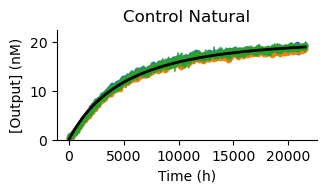

In [75]:
t = t_TUM_casc_controls[0:number_of_points]
data = TUM_casc_controls[0:number_of_points]
conditions = conditions_TUM_casc_controls
levels = [list(conditions.keys())[0]]
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]





def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale

    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt

        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1

def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result




# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e1


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

fitted_kf = np.mean(res)
param_sd_kf = np.std(res)

print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


casc_k_control_nat = [[fitted_kf,param_sd_kf]]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')


#plt.savefig('control_nat_k.svg', dpi = 400)
plt.show()



Fitted kf = 1.0e+04 ± 4.1e+02


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_59623/2118478586.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dY1dt = -float(kf*(R1)*(Y1))
/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_59623/2118478586.py:53: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]


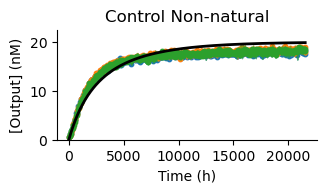

In [76]:
t = t_TUM_casc_controls[0:number_of_points]
data = TUM_casc_controls[0:number_of_points]
conditions = conditions_TUM_casc_controls
levels = [list(conditions.keys())[1]]
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_casc_controls[0:number_of_points])
offset = offset_TUM_casc_controls
format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []
for l in levels:
    curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
    stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]




to_fit = [c[1] for c in curves]

x_trunc = curves[0][0]




def modelOneStep(kf, tArray, fixed_params):

    t = tArray
    # Unpack the input parameters
    y0, scale = fixed_params['y0'], fixed_params['scale']

    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale



    def translatorModel(y, t, kf, scale):
        Y1, P, W = y
        # CRN:
        # Y1 + R1 -krep> P
        #Rate of reporting
        R1 = float(scale - P)
        dY1dt = -float(kf*(R1)*(Y1))
        dPdt = -dY1dt
        dWdt = dPdt



        return (dY1dt, dPdt, dWdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-1] for i in odeint(translatorModel, y0, t, args=(kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1




def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:d
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result  = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list))

    return result



# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





# Initial parameters
y_init = [
    20.0,  # Initial concentration of Y1  (0)
    0.0,  # Initial concentration of P   (1)
    0.0,  # Initial concentration of W   (2)


]

scale = 40



fixed_params_list = [
    {'y0': y_init, 'scale' : scale}
]


initial_k = 2e5


x_list  = [x_trunc]

res = []
for curve in to_fit[0]:
  res += [fit_modelOneStep(x_list, [curve], initial_k, fixed_params_list)[0]]

fitted_kf = np.mean(res)
param_sd_kf = np.std(res)

print(f"Fitted kf = {fitted_kf:.1e} ± {param_sd_kf:.1e}")


casc_k_control_nn = [[fitted_kf,param_sd_kf]]

fig, ax = plt.subplots(1,1, figsize = (3.25,2))
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)


alph = 0.5
size = 5
line = 2
for i,rep in enumerate(to_fit[0]):
  ax.scatter(x_trunc,[1e9*i for i in rep], color=color_scheme[i], s = 10)
  ax.fill_between(x_trunc,(np.array([1e9*i for i in rep])-np.array(stdDev[0][i])),np.array([1e9*i for i in rep]), color=color_scheme[i], alpha= alph)
  ax.fill_between(x_trunc,[1e9*i for i in rep],  (np.array([1e9*i for i in rep])+np.array(stdDev[0][i])), color=color_scheme[i], alpha= alph)
ax.plot(x,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[0])], 'black',linewidth=line)




ax.set_ylim(0,22.5)
ax.set_xlabel('Time (h)')
ax.set_title("Control Non-natural")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('[Output] (nM)')

#plt.savefig('control_nnn_k.svg', dpi = 400)

plt.show()



## No incubation

### Nat

Fitted kr_s = 25.64 ± 0.17
Fitted kr_s = 26.61 ± 3.03
Fitted kr_s = 2.70 ± 0.09
Fitted kr_s = 1.99 ± 0.12


/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_59623/398438001.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kb_off = float(kb_off)


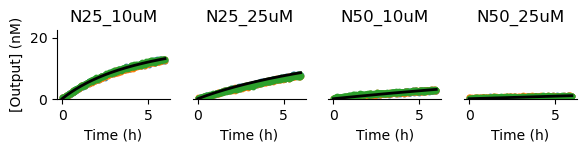

In [77]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nat
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [0, 2, 4, 6]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kb_off, tArray, fixed_params):
    t = tArray
    # Unpack the input parameters
    y0, kf, scale = fixed_params['y0'], fixed_params['kf'], fixed_params['scale']
    y0 = y0[0:1] + [scale] + y0[1:]
    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale
    kb_off = float(kb_off)
    def translatorModel(y, t, kb_off, kf, scale):
        kb_off = float(kb_off)

        Y1, R1, P, W, B, S = y
        # CRN:
        # Y1 + R1 -krep> P + W
        # Y1 + B <-kb_off kb_on->  S
        #Rate of reporting
        kb_on = 1e7
        dR1dt = -float(kf*(R1)*(Y1))
        dY1dt = -float(kf*(R1)*(Y1)) -float(kb_on*(B)*(Y1)) + float(kb_off*S)
        dPdt = float(kf*(R1)*(Y1))
        dWdt = dPdt
        dBdt = -float(kb_on*(B)*(Y1)) + float(kb_off*S)
        dSdt = float(kb_on*(B)*(Y1)) - float(kb_off*S)

        return (dY1dt, dR1dt, dPdt, dWdt, dBdt, dSdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-3] for i in odeint(translatorModel, y0, t, args=(kb_off, kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1


def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





B_concs = [10000, 25000, 10000, 25000]
# Initial parameters
y_init = [
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[0],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[1],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[2],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[3],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)  
]

scale = 40

k_cont = k_control_nat[0][0]
fixed_params_list = [
    [{'y0': y_init[0], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[1], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[2], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[3], 'kf': k_cont, 'scale' : scale}]
]


initial_k = [31, 31, 1, 1]

x_list  = [x_trunc]




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2


casc_kb_no_nat = []
x_trunc_h = [t/3600 for t in x_trunc]
x_h = [t/3600 for t in x]
for i,a in enumerate(ax):
    

    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        r = fit_modelOneStep(x_list, [curve], initial_k[i], fixed_params_list[i])[0][0]
        res.append(r)

        a.scatter(x_trunc_h,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc_h,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc_h,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)

    fitted_kf = np.mean(res)
    param_sd_kf = np.std(res)
    casc_kb_no_nat.append([fitted_kf, param_sd_kf])
    print(f"Fitted kr_s = {fitted_kf:.2f} ± {param_sd_kf:.2f}")

    #k_no_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i][0])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()



### NN

/var/folders/st/ms2z6hjx45q_b_lh489s7vk00000gq/T/ipykernel_59623/170911729.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kb_off = float(kb_off)


Fitted  kr_s = 29.10 ± 0.63
Fitted  kr_s = 31.63 ± 0.89
Fitted  kr_s = 4.04 ± 0.28
Fitted  kr_s = 2.60 ± 0.09


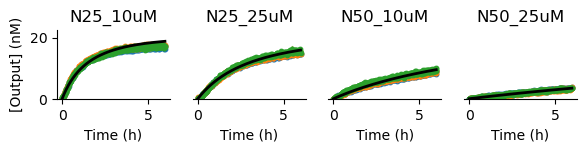

In [78]:
labels = ['N25_10uM', 'N25_25uM', 'N50_10uM', 'N50_25uM']


data = TUM_no[0:number_of_points]
conditions = conditions_TUM_no
levels = list(conditions.keys())
offset = offset_TUM_no
fit = fit_nn
start = timeToSec("0:00:00")
x = np.array(t_TUM_no[0:number_of_points])

format_dict = {'point_size': 10, 'point_opacity': 1, 'fill_opacity': 0.8}

curves = []
stdDev = []

for i, l in enumerate(levels):
    if i in [1, 3, 5, 7]:
      curves += [[getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[0],[1e-9*np.array(c) for c in getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[1]]]]
      stdDev += [getTriplicatesJackknife(start, offset, l, x, data, conditions, fit)[2]]


to_fit = [c[1] for c in curves]


x_trunc = curves[0][0]


def modelOneStep(kb_off, tArray, fixed_params):
    t = tArray
    # Unpack the input parameters
    y0, kf, scale = fixed_params['y0'], fixed_params['kf'], fixed_params['scale']
    y0 = y0[0:1] + [scale] + y0[1:]
    y0 = [i*1e-9 for i in y0]
    scale = 1e-9*scale
    kb_off = float(kb_off)
    def translatorModel(y, t, kb_off, kf, scale):
        kb_off = float(kb_off)

        Y1, R1, P, W, B, S = y
        # CRN:
        # Y1 + R1 -krep> P + W
        # Y1 + B <-kb_off kb_on->  S
        #Rate of reporting
        kb_on = 1e7
        dR1dt = -float(kf*(R1)*(Y1))
        dY1dt = -float(kf*(R1)*(Y1)) -float(kb_on*(B)*(Y1)) + float(kb_off*S)
        dPdt = float(kf*(R1)*(Y1))
        dWdt = dPdt
        dBdt = -float(kb_on*(B)*(Y1)) + float(kb_off*S)
        dSdt = float(kb_on*(B)*(Y1)) - float(kb_off*S)

        return (dY1dt, dR1dt, dPdt, dWdt, dBdt, dSdt)

    #Solve transalot model based on initial conditions and fit
    y1 = [i[-3] for i in odeint(translatorModel, y0, t, args=(kb_off, kf, scale), rtol = 1e-12, atol = 1e-12)]
    if (kf < 0):
      return [np.inf]*len(y1)

    return y1


def residuals(kf, t, yList, fixed_params_list):
    # Loop through each set of y values and fixed parameters and calculate the residuals
    total_residuals = []
    n=0
    for y, fixed_params in zip(yList, fixed_params_list):
        tfull = np.arange(0, t[n][-1]+(t[n][-1]-t[n][-2]),t[n][-1]-t[n][-2])
        mindex = min([i for i in range(len(tfull)) if tfull[i]>= t[n][0]])
        model_y = modelOneStep(kf, t[n], fixed_params)[mindex:] # I need to update this so that the model is calculaed starting from 0 then a fraction of it is fit
        total_residuals.append(y - model_y)
        n += 1

    # Concatenate all the residuals into one array
    return np.concatenate(total_residuals)
def fit_modelOneStep(tArray, yList, initial_k, fixed_params_list):
    """
    Function to perform fitting for multiple cascades.

    Parameters:
    - tArray: Array of 'x' values (time values) for the cascades.
    - yList: List of 'y' values for each cascade.
    - initial_k_rep: Initial guess for the reporterRate.
    - fixed_params_list: A list of dictionaries, each containing all other parameters which are kept constant for a particular cascade.

    Returns:
    - k_rep: Fitted reporterRate.
    """
    # Fit the model to the data
    result, cov_x, infodict, mesg, ier = leastsq(residuals, initial_k, args=(tArray, yList, fixed_params_list), full_output=True)

    return result, cov_x


# Define the 'x' values and 'y' values
tArray = np.linspace(0, 10, 100)
yMatrix = np.random.normal(size=(3, len(tArray)))  # three sets of data





B_concs = [10000, 25000, 10000, 25000]

# Initial parameters
y_init = [
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[0],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[1],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[2],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)
    [   20.0,  # Initial concentration of Y1  (0)
        0.0,  # Initial concentration of P   (1)
        0.0,  # Initial concentration of W   (2)
        B_concs[3],  # Initial concentration of B   (3)
        0.0 ],  # Initial concentration of S   (4)  
]

scale = 40

k_cont = k_control_nn[0][0]
fixed_params_list = [
    [{'y0': y_init[0], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[1], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[2], 'kf': k_cont, 'scale' : scale}],
    [{'y0': y_init[3], 'kf': k_cont, 'scale' : scale}]
]


initial_k = [31, 31, 5, 1]

x_list  = [x_trunc]




fig, ax = plt.subplots(1,4, figsize = (6.5,1.25), sharey=True)
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.75)

alph = 0.5
size = 5
line = 2


casc_kb_no_nn = []
x_trunc_h = [t/3600 for t in x_trunc]
x_h = [t/3600 for t in x]
for i,a in enumerate(ax):
    res = []
    for j,curve in enumerate(to_fit[i]):
        c = [1e9*e for e in curve]
        r = fit_modelOneStep(x_list, [curve], initial_k[i], fixed_params_list[i])[0][0]
        res.append(r)

        a.scatter(x_trunc_h,c, color=color_scheme[j], s = 10)
        a.fill_between(x_trunc_h,(np.array(c)-np.array(stdDev[i][j])),np.array(c), color=color_scheme[j], alpha= alph)
        a.fill_between(x_trunc_h,c,  (c+np.array(stdDev[i][j])), color=color_scheme[j], alpha= alph)


    fitted_kf = np.mean(res)
    param_sd_kf = np.std(res)
    casc_kb_no_nn.append([fitted_kf, param_sd_kf])
    print(f"Fitted  kr_s = {fitted_kf:.2f} ± {param_sd_kf:.2f}")

    #k_no_nat.append([fitted_kf,param_sd_kf])
    a.plot(x_h,[i*1e9 for i in modelOneStep(fitted_kf, x, fixed_params_list[i][0])], color='black',linewidth=line)

    a.set_xlabel('Time (h)')
    a.set_title(f"{labels[i]}")
    a.spines['left'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.get_yaxis().set_visible(False)
ax[0].get_yaxis().set_visible(True)
ax[0].spines['left'].set_visible(True)
ax[0].set_ylim(0,22.5)

ax[0].set_ylabel('[Output] (nM)')

#plt.savefig('TUM_nat_noinc.svg', dpi = 500, transparent=True)
plt.show()


# Summary graphic

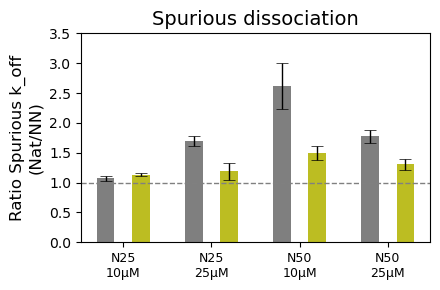

Condition N25
10μM: p-value = 0.3825
Condition N25
25μM: p-value = 0.0421
Condition N50
10μM: p-value = 0.1183
Condition N50
25μM: p-value = 0.0212


One-step,N25_10μM:
	p-value = 0.6541
One-step,N25_25μM:
	p-value = 0.0335
One-step,N50_10μM:
	p-value = 0.1500
One-step,N50_25μM:
	p-value = 0.0531
Multi-step,N25_10μM:
	p-value = 0.0954
Multi-step,N25_25μM:
	p-value = 1.1501
Multi-step,N50_10μM:
	p-value = 0.1409
Multi-step,N50_25μM:
	p-value = 0.2297


In [99]:

def prop_err(res_num, res_denom):
    return np.sqrt(((1/res_denom[0])*res_num[1])**2 + ((res_num[0]/(res_denom[0]**2))*res_denom[1])**2)

# Input labels and data
group_labels = ['N25\n10\u03bcM', 'N25\n25\u03bcM', 'N50\n10\u03bcM', 'N50\n25\u03bcM']
conditions = ['One-step', 'Multi-step']
colors = [color_scheme[7], color_scheme[8]]
bar_width = 0.2



# Prepare experimental data
no = [kb_no_nat, kb_no_nn]
no_casc = [casc_kb_no_nat, casc_kb_no_nn]
systems = [no, no_casc]

# fold[i][j]: condition i, group j
n_groups = len(group_labels)
n_conditions = len(systems)

fold = np.zeros((n_conditions, n_groups))
e_fold = np.zeros((n_conditions, n_groups))

for i, sys in enumerate(systems):
    for j in range(n_groups):
        fold[i, j] = sys[1][j][0] / sys[0][j][0]
        e_fold[i, j] = prop_err(sys[1][j], sys[0][j])

# Set up x-axis positions
x_control = 0
x_group_start = 0  # reserve space for control
x_group = np.arange(n_groups) + x_group_start  # center position for each group
x_offsets = np.linspace(-bar_width, bar_width, n_conditions)  # offset for each bar in a group

# Plot
fig, ax = plt.subplots(figsize=(4.5, 3))
error_params = dict(ecolor='black', lw=1, capsize=4, capthick= 0.5)



# Grouped bars
for i in range(n_conditions):
    ax.bar(x_group + x_offsets[i], fold[i], bar_width, yerr=e_fold[i],
           color=colors[i], label=conditions[i], error_kw=error_params)

# Format x-axis
x_ticks = list(x_group)
x_labels =  group_labels
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, rotation=0, fontsize=9)

ax.set_ylabel('Ratio Spurious k_off\n(Nat/NN)', fontsize=12)
ax.set_ylim(0, 3.5)
ax.set_title('Spurious dissociation', fontsize=14)

ax.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
#plt.savefig("Onestep_InitK_grouped_barplot_err.svg", dpi=400)
plt.show()


#condunct two tailed t-test by handto see if the means are significantly different between conditions and between groups
from scipy.stats import ttest_ind_from_stats

for i in range(n_groups):
    stat, p_value = ttest_ind_from_stats(
        mean1=fold[0][i],
        std1=e_fold[0][i],
        nobs1=3,
        mean2=fold[1][i],
        std2=e_fold[1][i],
        nobs2=3,
        equal_var=False
    )


# apply bonferroni correction for total number of tests (4 between groups)
    p_value *= n_groups
    print(f"Condition {group_labels[i]}: p-value = {p_value:.4f}")
    
print("\n")
# Single sample t-test with bonferoni correction to see if the means are signlificantly different from 1 (no difference between nat and nn) for each bar
for i in range(n_conditions):
    for j in range(n_groups):
        stat, p_value = ttest_ind_from_stats(
            mean1=fold[i][j],
            std1=e_fold[i][j],
            nobs1=3,
            mean2=1,
            std2=0,
            nobs2=4,
            equal_var=False
        )

        # apply Holm-bonferroni correction
        p_value *= n_conditions * n_groups
        print(f"{conditions[i]},{group_labels[j].replace("\n", "_")}:\n\tp-value = {p_value:.4f}")